# Cad: Usd Exchange Rate Prediction (Based on data from 2007-2018)

for TRY Conference (2018) 
by Josephine Choi and Lei Jin 


## Background

This Jupyter  Notebook is created based on webposts by Illiya Valchanov / Rohit Garg 

Illiya Valchanov 
https://datascienceplus.com/how-to-apply-monte-carlo-simulation-to-forecast-stock-prices-using-python/ (Dec 2017) 

Rohit Garg 
https://analyticsindiamag.com/a-primer-to-monte-carlo-simulation-in-python/ (Mar 2018)

The original code is for building a monte carlo simulation model for stock pricing 

The following YouTube video are helpful in understanding monte carlo simulation 

Understanding and creating Monte Carlo Simulation Step by Step 
https://www.youtube.com/watch?v=3gcLRU24-w0



In [392]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import numpy as np
from scipy.stats import norm

## Step 1: Loading the data into Python

- Daily exchange rate data can be found through Bank of Canada website
- As part of the preprocessing, files were downloaded yearly and need to be combined
- Data might be also available through REST API (e.g. quandl) 



In [393]:
Ex2012 = pd.read_excel("data/Ex2012.xlsx",parse_dates=True,index_col=0)
Ex2013 = pd.read_csv("data/Ex2013.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2014 = pd.read_csv("data/Ex2014.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2015 = pd.read_csv("data/Ex2015.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2016 = pd.read_csv("data/Ex2016.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2017 = pd.read_csv("data/Ex2017.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2018 = pd.read_csv("data/Ex2018.csv",skiprows=8,parse_dates=True,index_col=0)

Ex2011 = pd.read_csv("data/Ex2011.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2010 = pd.read_csv("data/Ex2010.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2009 = pd.read_csv("data/Ex2009.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2008 = pd.read_csv("data/Ex2008.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2007 = pd.read_csv("data/Ex2007.csv",skiprows=8,parse_dates=True,index_col=0)


Ex = Ex2007.append(Ex2008).append(Ex2009).append(Ex2010).append(Ex2011).append(Ex2012).append(Ex2013).append(Ex2014).append(Ex2015).append(Ex2016).append(Ex2017).append(Ex2018)
Ex.sample(5)


,IEXE0101
date,
2012-01-26 00:00:00,0.9986
2007-09-05 00:00:00,1.0508
2013-06-21,1.0470
2013-05-21,1.0277
2017-02-08 00:00:00,1.3157



## Step 2: Inspect the data and Cleaning the data for model

- Unlike spreadsheet tools like Excel, data inspection through statistics tools (e.g. R) or programming language (e.g. Python) do not rely on visual inspection
- Here are some of the commands that are useful for inspecting data in python 
  * df.describe()
  * df.sample()
  * df.info()
- Remove erroneous data 
- Missing data can be filled with a) mean b) mode c) backfilling or forward filling 
- Make sure the data types were set up correctly
- Inspect the data again before moving forward to the next stage 


In [394]:
Ex.describe()
Ex.sample(20)
Ex['date']=Ex.index.values


#Don't know whether these were coming from 

Ex=Ex[Ex.date!='ERROR']
Ex=Ex[Ex.date!='date']
Ex=Ex[Ex.IEXE0101 != -64]
Ex=Ex[Ex.IEXE0101 != '-64']

# Opted to fill the bank holiday (empty fields) with forward filling (ffill). Back filling should do the trick as well 
Ex.IEXE0101=Ex['IEXE0101'].fillna(method="ffill")
Ex["IEXE0101"]=Ex["IEXE0101"].fillna(1)

#Set the type to the correct type 
Ex['IEXE0101'] = Ex['IEXE0101'].astype('float')

Ex['date'] = Ex['date'].astype('datetime64[ns]')

#for some strange reason, there were dates >2019, and thus needs to be removed

Ex=Ex[Ex.date<'2019-01-01']
#Ex.date = Ex.date.apply(pd.to_datetime, format='%d/%m/%Y')
Ex.sort_values(by=['date'])
Ex.set_index(Ex.date,inplace=True)


Ex=Ex.drop('date', axis=1)
#Ex.index=Ex['date']



In [395]:
Ex.info()

print("-"*40)

Ex.describe()
#Ex.drop('date',axis=1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2777 entries, 2007-05-01 to 2018-03-15
Data columns (total 1 columns):
IEXE0101    2777 non-null float64
dtypes: float64(1)
memory usage: 43.4 KB
----------------------------------------


,IEXE0101
count,2777.000000
mean,1.123416
std,0.130128
min,0.917000
25%,1.015600
50%,1.067100
75%,1.253300
max,1.458900


## Step 3: Building the financial model

- Inspect the general trend of existing data 
- We see gradual growth over the past five years
- Five years of past data may not be enough: Model may be biased because of the past performance 


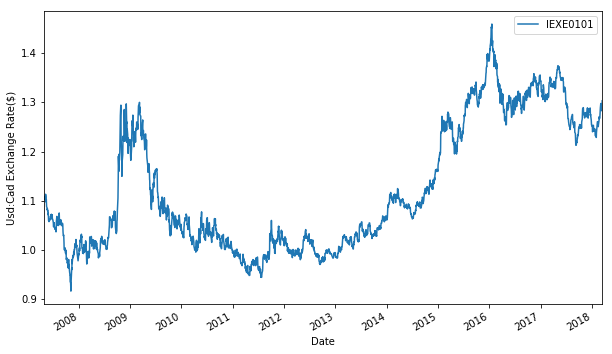

In [396]:

log_returns = np.log(1 + Ex['IEXE0101'].pct_change())
log_returns.tail()

type(log_returns)

Ex.plot(figsize=(10,6))
plt.ylabel("Usd:Cad Exchange Rate($)")
plt.xlabel("Date")
plt.show();


- Plotting the log returns

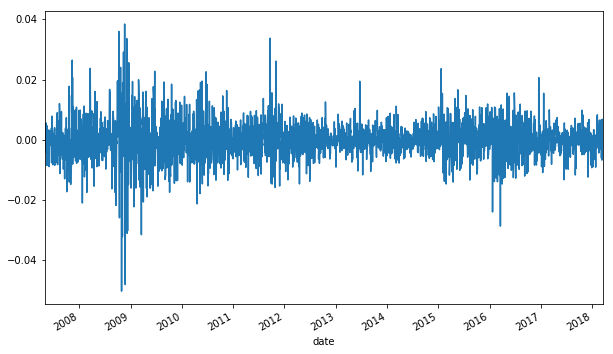

In [397]:
log_returns.plot(figsize=(10,6));

### Finding out the variables required for the calculation of Brownian motion 
- Brownian motion : the formula was first used to model random movement in physics. But has been used to predict the movement of an asset in finance  
- Brownian motion assumes two part of the random movement
  * drift(a constant driving force)
  * random stochastic component(random component) 
- We need 
  * mean 
  * variance (historical volatility) 


In [398]:
u=log_returns.mean()
u
type(u)

float

In [399]:
var=log_returns.var()
var

4.036247883722143e-05

- Brownian motion assumes two parts of movement 
- Drift is the expected rate of return 
- Today's price = Yesterday's price * e ** r
- For standard Monte Carlo : average of historical return - (variance/2) 
- There are other theories are what the drift would be 
 * risk free rate - (variance/2)
 * 0 (supported by random walk theory) 
 



In [400]:
drift=u-(0.5*var)
drift

3.7979511780476366e-05

In [401]:
stdev = log_returns.std()
stdev

0.006353147160047643

In [402]:
#type(drift)
#type(stdev)

In [403]:
drift=np.array(drift)
#type(drift)

In [404]:
#stdev=np.array(stdev)
#type(stdev)
#drift.values
#stdev.values
#norm.ppf(0.95)

For the random component, we need to randomize. This can be done by numpy "rand" function. As an example, the following code will create a multidimensional array


In [405]:
x=np.random.rand(10,2)
x
norm.ppf(x)

array([[-0.99784388,  0.60990349],
       [-1.26187743,  1.09405831],
       [ 1.26763928, -1.92370003],
       [-0.60008875, -0.03530176],
       [ 0.54834766, -0.8683478 ],
       [ 0.6219507 , -0.6272521 ],
       [ 0.59441619, -0.65115001],
       [ 0.81593562, -0.54804846],
       [ 0.65461599, -0.01792949],
       [ 1.02055159, -1.37876085]])

In [406]:
Z=norm.ppf(np.random.rand(10,2))
Z

array([[ 1.3134596 , -1.82331649],
       [-0.01747   ,  0.51838405],
       [-0.04316322,  0.98293494],
       [-0.78874827, -0.69872621],
       [ 0.60701456,  0.21015049],
       [ 0.31478023,  0.76292884],
       [ 0.0208104 , -0.08733708],
       [ 0.54608301,  0.84743765],
       [ 0.88362686, -1.63299948],
       [-0.46322767,  0.19745294]])

The following code set the number of iterations (the number of trials) and t_intervals (the length of projection)  

In [407]:
t_intervals=1000
iterations=500

This is the formula we used to build our model 
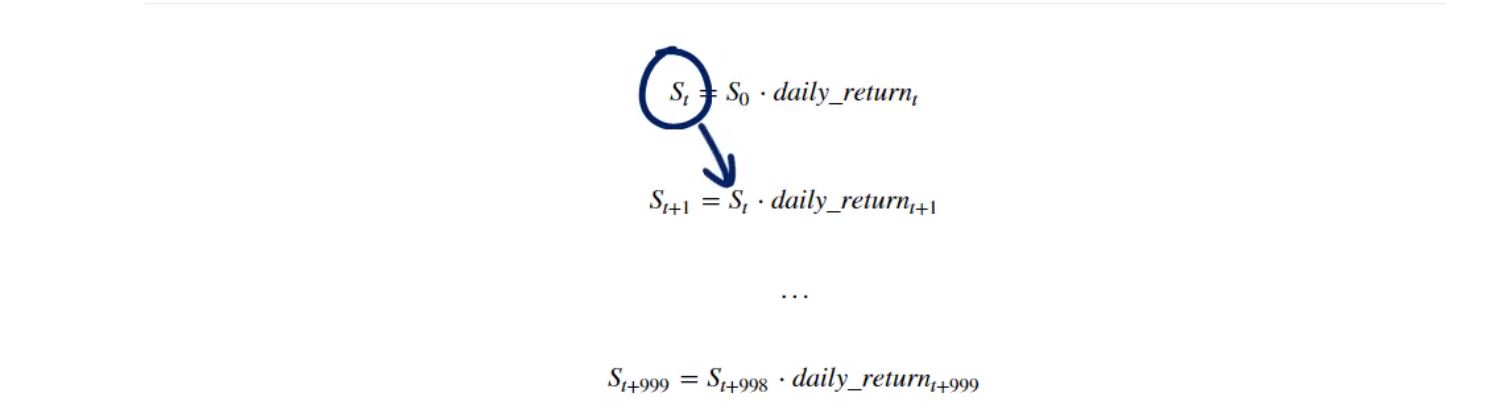

In [408]:
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

In [409]:
type(daily_returns)

numpy.ndarray

In [410]:
S0=Ex.iloc[-1,0]
S0

1.3031999999999999

In [411]:
price_list=np.zeros_like(daily_returns)

In [412]:
price_list

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [413]:
price_list[0]=S0
price_list

array([[ 1.3032,  1.3032,  1.3032, ...,  1.3032,  1.3032,  1.3032],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ..., 
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

In [414]:
for t in range(1,t_intervals):
    price_list[t]=price_list[t-1]*daily_returns[t]

In [415]:
price_list


array([[ 1.3032    ,  1.3032    ,  1.3032    , ...,  1.3032    ,
         1.3032    ,  1.3032    ],
       [ 1.30247122,  1.29497948,  1.30853907, ...,  1.3006064 ,
         1.30347837,  1.29838668],
       [ 1.30864386,  1.3143643 ,  1.32462048, ...,  1.31425769,
         1.31209737,  1.29449668],
       ..., 
       [ 1.2616327 ,  1.38925831,  1.3296833 , ...,  1.50687608,
         1.33902281,  1.18276877],
       [ 1.26426601,  1.38772437,  1.32557269, ...,  1.5040769 ,
         1.32579122,  1.18131308],
       [ 1.26371618,  1.37765835,  1.3162529 , ...,  1.52255789,
         1.32257026,  1.19287974]])

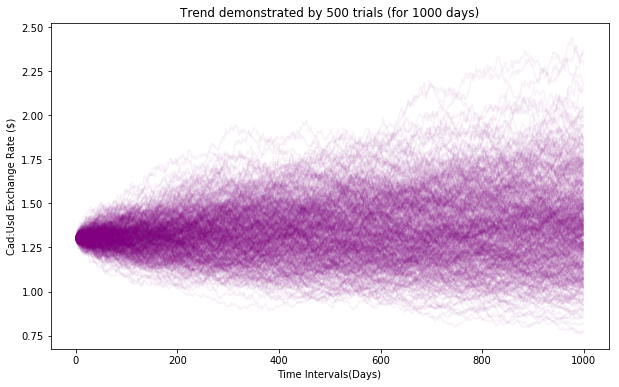

In [416]:
plt.figure(figsize=(10,6));
plt.plot(price_list,color="purple",alpha=0.05);
plt.xlabel("Time Intervals(Days)")
plt.ylabel("Cad:Usd Exchange Rate ($)")
plt.title("Trend demonstrated by 500 trials (for 1000 days)");

In [417]:
price_list.shape

prediction=pd.DataFrame(price_list)
prediction.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,...,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200
1,1.302471,1.294979,1.308539,1.300091,1.307572,1.297771,1.307920,1.296717,1.296984,1.309867,...,1.312879,1.297612,1.316767,1.305717,1.284885,1.303373,1.316826,1.300606,1.303478,1.298387
2,1.308644,1.314364,1.324620,1.285547,1.306705,1.296727,1.305844,1.302024,1.304118,1.305576,...,1.323715,1.311067,1.325184,1.311943,1.282432,1.296607,1.308609,1.314258,1.312097,1.294497
3,1.299454,1.324915,1.326207,1.297837,1.314268,1.292847,1.285956,1.307855,1.319582,1.308528,...,1.318246,1.300468,1.316914,1.314659,1.277735,1.298356,1.286228,1.312343,1.318686,1.298694
4,1.283411,1.318416,1.322148,1.292227,1.317906,1.279622,1.285670,1.302666,1.322634,1.295649,...,1.321829,1.302942,1.322185,1.315431,1.287758,1.298630,1.285815,1.303718,1.314743,1.315202


## Step 4: Analysis 

 - The Monte Carlo simulation allows us to speculate the foreign exchange rate based on a selected timeframe. 
 - It is different from a regular projection because we can now quantify probability. This was made possible by central limit theorum 
 

### Central Limit Theorum 
- if we graph enough periodical daily returns of an asset, the graph should form a normal distribution, bell shaped graph

TP = YS * e ** r
TP = Tomorrow's stock price 
S = Today's stock price 
r = periodical daily rate of return


In [418]:
pred=prediction.iloc[365,:]

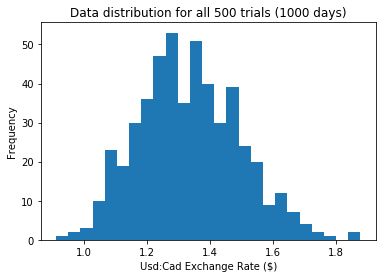

In [419]:


plt.hist(pred,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)");
plt.title("Data distribution for all 500 trials (1000 days)")
plt.show()

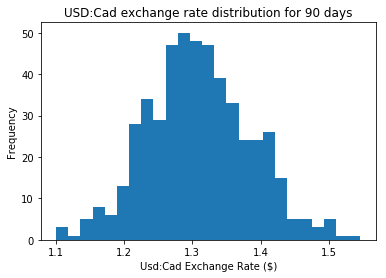

The mean for 90th day distribution is 1.334256
Probability of exchange rate over 1.4 after 90 days: 13 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.309964
std        0.075548
min        1.100779
25%        1.259899
50%        1.307168
75%        1.357888
max        1.546027
Name: 90, dtype: float64

In [420]:
pred90=prediction.iloc[90,:]
mean90=pred.mean()

pred1=prediction.iloc[90,:]>1.4
prob=pred1.sum()/500 *100

plt.hist(pred90,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 90 days");
plt.show()



print("The mean for 90th day distribution is %f" %(mean90))
print( "Probability of exchange rate over 1.4 after 90 days: %d percent" %(prob))

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[90,:].describe()

0.302951413791


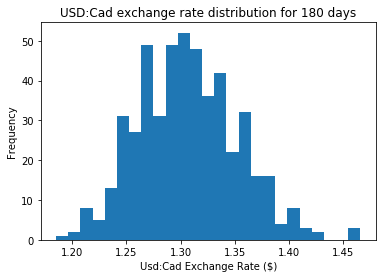

The mean for 180th day distribution is 1.334256
Probability of exchange rate over 1.25 after 30 days: 89 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.306930
std        0.045874
min        1.185054
25%        1.272837
50%        1.305290
75%        1.337825
max        1.465823
Name: 30, dtype: float64

In [436]:
pred180=prediction.iloc[30,:]

mean180=pred.mean()

pred2=prediction.iloc[30,:]>1.25 
std1=pred2.std()
print(std1)

plt.hist(pred180,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 180 days");
plt.show()


prob=pred2.sum()/500 *100

print("The mean for 180th day distribution is %f" %(mean180))

print( "Probability of exchange rate over 1.25 after 30 days: %d percent" %(prob))

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[30,:].describe()

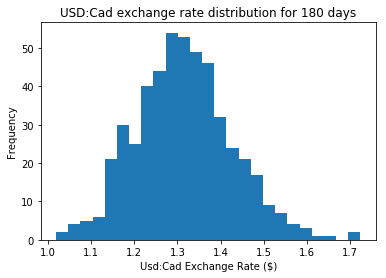

The mean for 180th day distribution is 1.334256
Probability of exchange rate over 1.4 after 180 days: 19 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.314617
std        0.111663
min        1.018757
25%        1.241330
50%        1.311124
75%        1.380144
max        1.724041
Name: 180, dtype: float64

In [421]:
pred180=prediction.iloc[180,:]
mean180=pred.mean()

pred2=prediction.iloc[180,:]>1.4


plt.hist(pred180,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 180 days");
plt.show()


prob=pred2.sum()/500 *100

print("The mean for 180th day distribution is %f" %(mean180))

print( "Probability of exchange rate over 1.4 after 180 days: %d percent" %(prob))

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[180,:].describe()

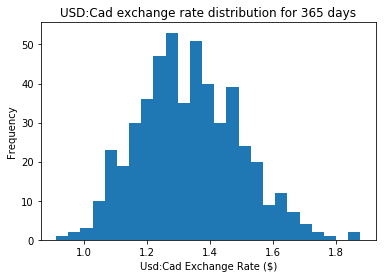

The mean for 365th day distribution is 1.334256
Probability of exchange rate over 1.4 after 365 days: 32 percent
Probability of exchange rate less than 1.31 after 365 days: 46 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.334256
std        0.160163
min        0.912310
25%        1.222968
50%        1.329647
75%        1.450018
max        1.878501
Name: 365, dtype: float64

In [422]:
pred365=prediction.iloc[365,:]

mean365= prediction.iloc[365,:].mean()

pred3=prediction.iloc[365,:]>1.4
pred2=prediction.iloc[365,:]<1.31
prob1 =(pred3.sum()/500) *100
prob2=(pred2.sum()/500)*100

plt.hist(pred365,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 365 days");
plt.show()

print("The mean for 365th day distribution is %f" %(mean365))
print( "Probability of exchange rate over 1.4 after 365 days: %d percent" %(prob1)) 
print( "Probability of exchange rate less than 1.31 after 365 days: %d percent" %(prob2)) 

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[365,:].describe()
